# **Predict Students**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
url='dataset.csv'
df=pd.read_csv(url,sep=',')
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [9]:
df.shape

(4424, 35)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [11]:
print(f'El total de valores nulos es : {df.isnull().sum().sum()}')
print(df.isnull().sum())

El total de valores nulos es : 0
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                  

## **EDA**

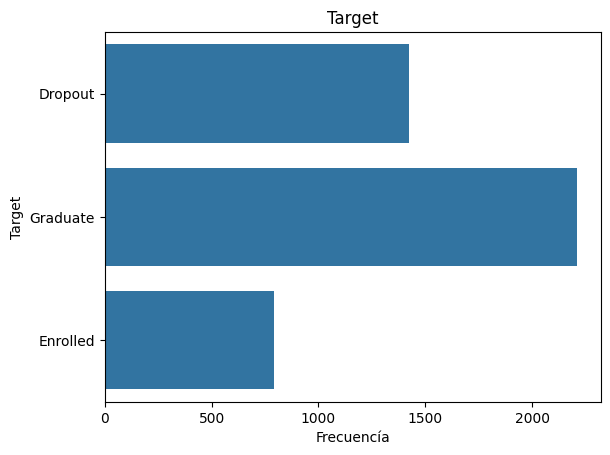

In [12]:
categorical_columns=df.select_dtypes(include='object').columns
categorical_columns
sns.countplot(df[categorical_columns[0]])
plt.title(categorical_columns[0])
plt.xlabel('Frecuencía')
plt.show()

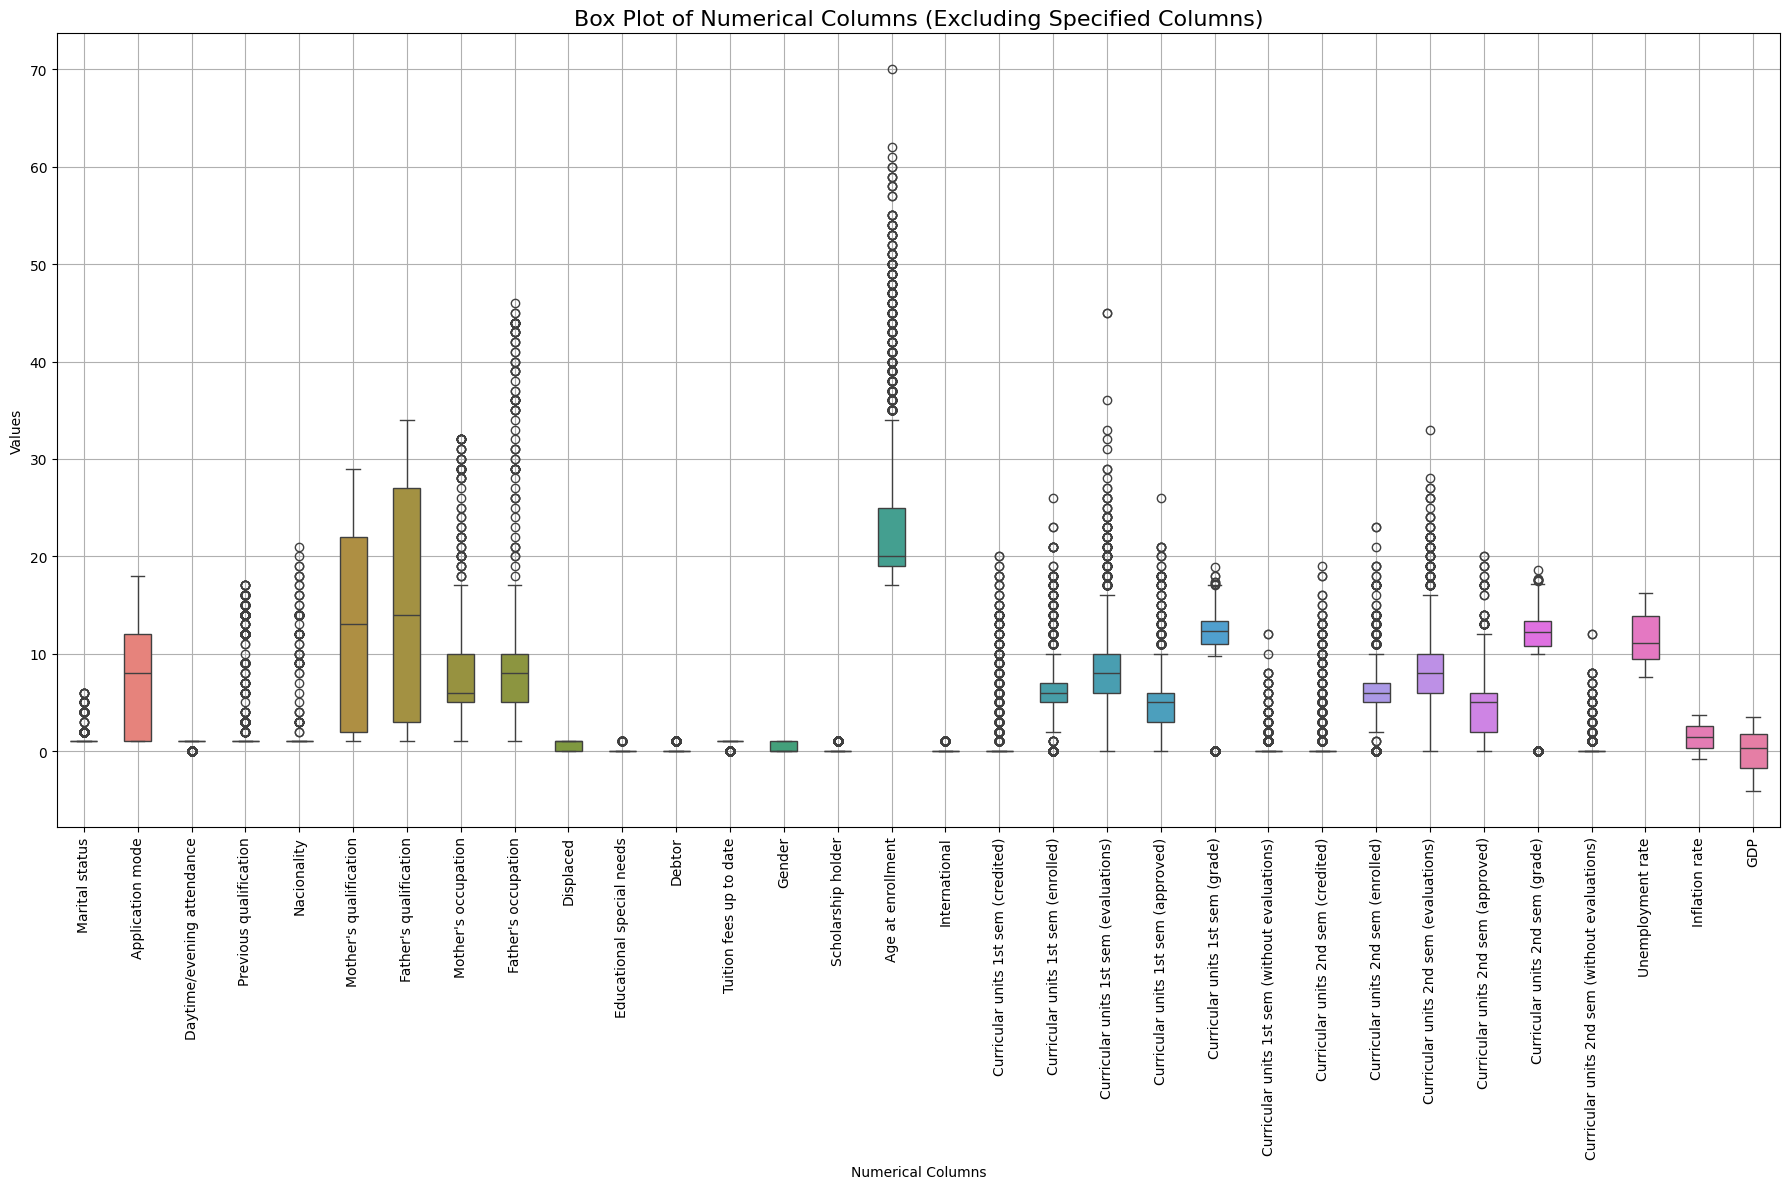

In [13]:
exclude_columns=['Application order', 'Course']
numerical_columns=df.select_dtypes(include=['number']).drop(columns=exclude_columns).columns
numerical_columns
plt.figure(figsize=(18,12))
sns.boxplot(data=df[numerical_columns],orient='v',width=0.5)
plt.title('Box Plot of Numerical Columns (Excluding Specified Columns)', fontsize=16)
plt.xlabel('Numerical Columns')
plt.ylabel('Values')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
len(numerical_columns)

32

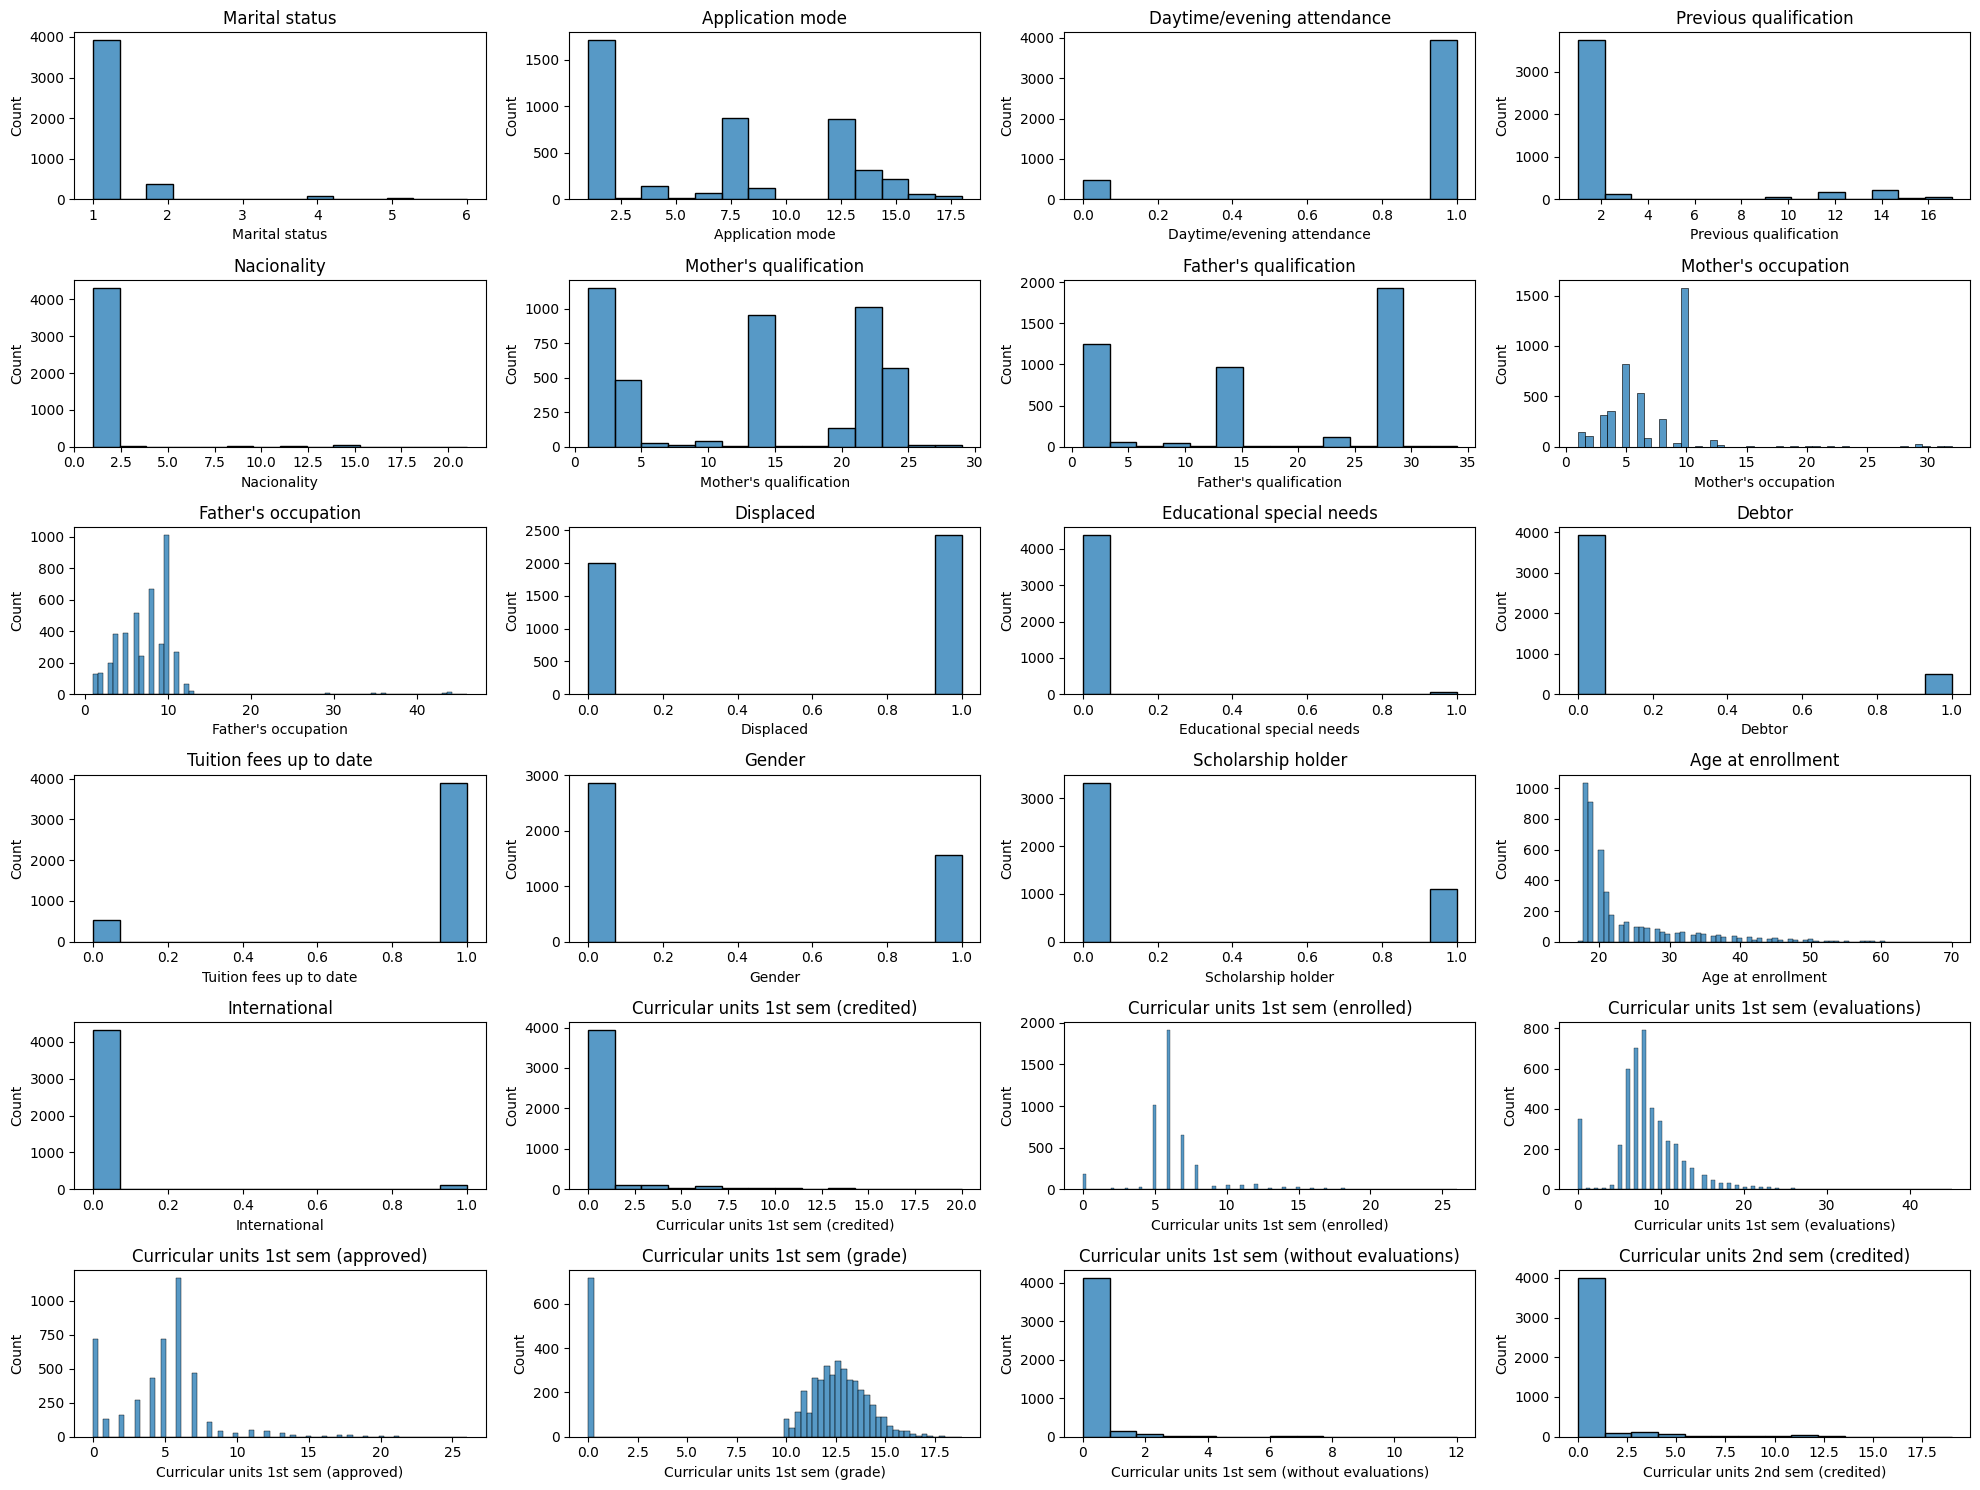

In [15]:
n_col=4
n_rows=6
fig,axs=plt.subplots(n_rows,n_col,figsize=(20,15))
for i,ax in enumerate(axs.flat):
    if i < len(numerical_columns):
        sns.histplot(data=df,x=numerical_columns[i],ax=ax)
        ax.set_title(numerical_columns[i])
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

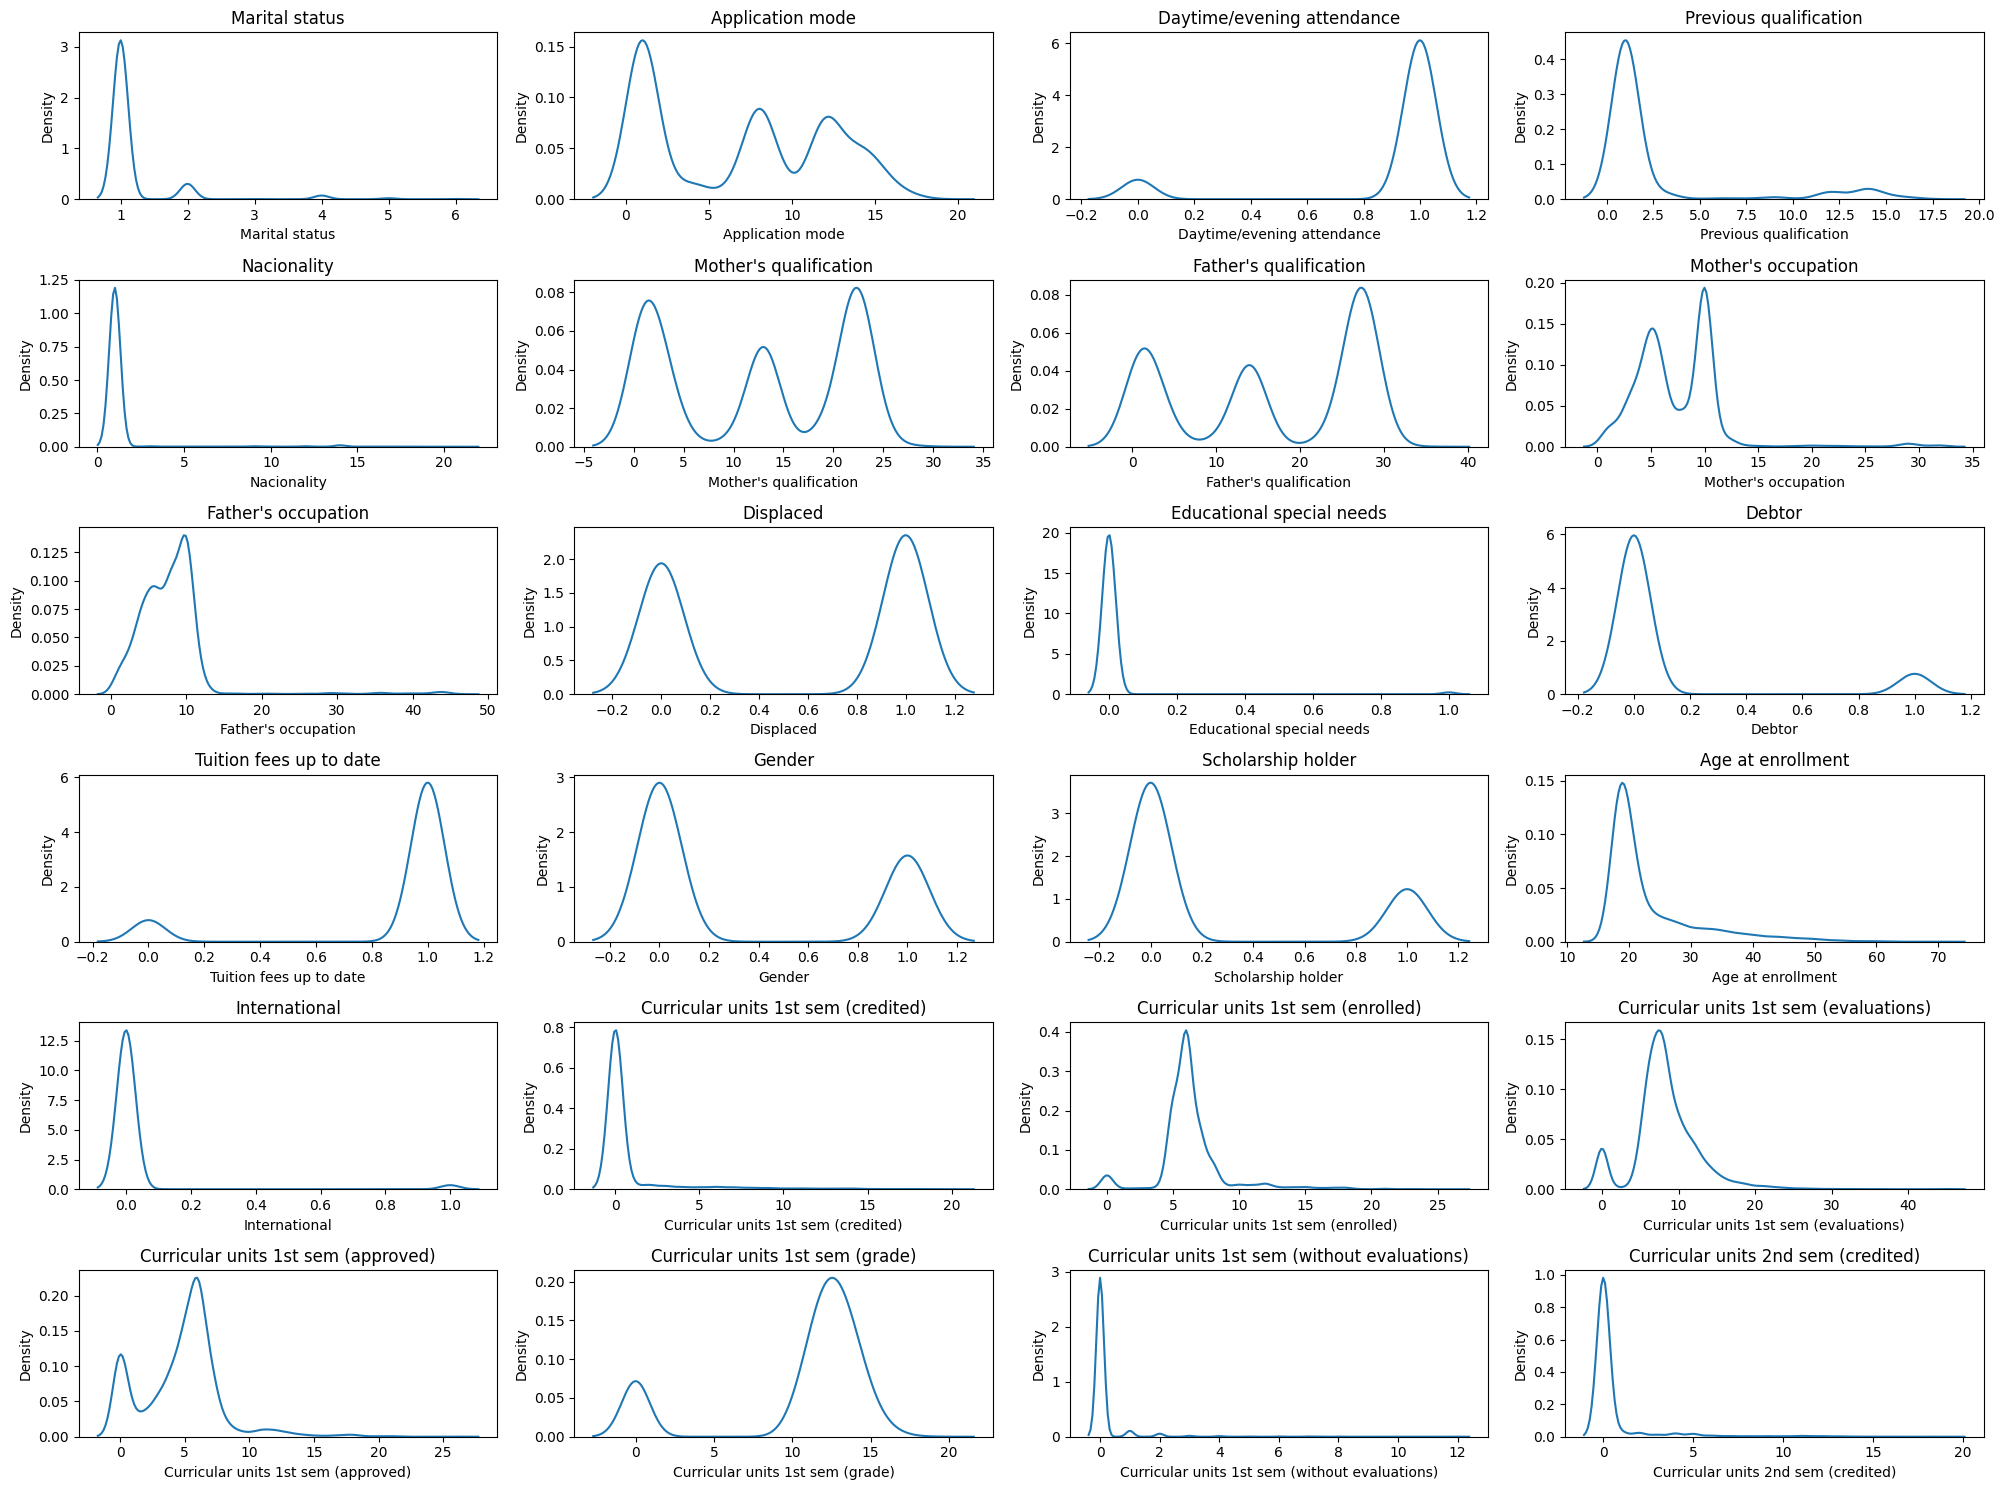

In [16]:
n_col=4
n_rows=6
fig,axs=plt.subplots(n_rows,n_col,figsize=(20,15))
for i,ax in enumerate(axs.flat):
    if i < len(numerical_columns):
        sns.kdeplot(data=df,x=numerical_columns[i],ax=ax)
        ax.set_title(numerical_columns[i])
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [17]:
le=LabelEncoder()
df['Target']=le.fit_transform(df['Target'])
df['Target'].value_counts()

Target
2    2209
0    1421
1     794
Name: count, dtype: int64

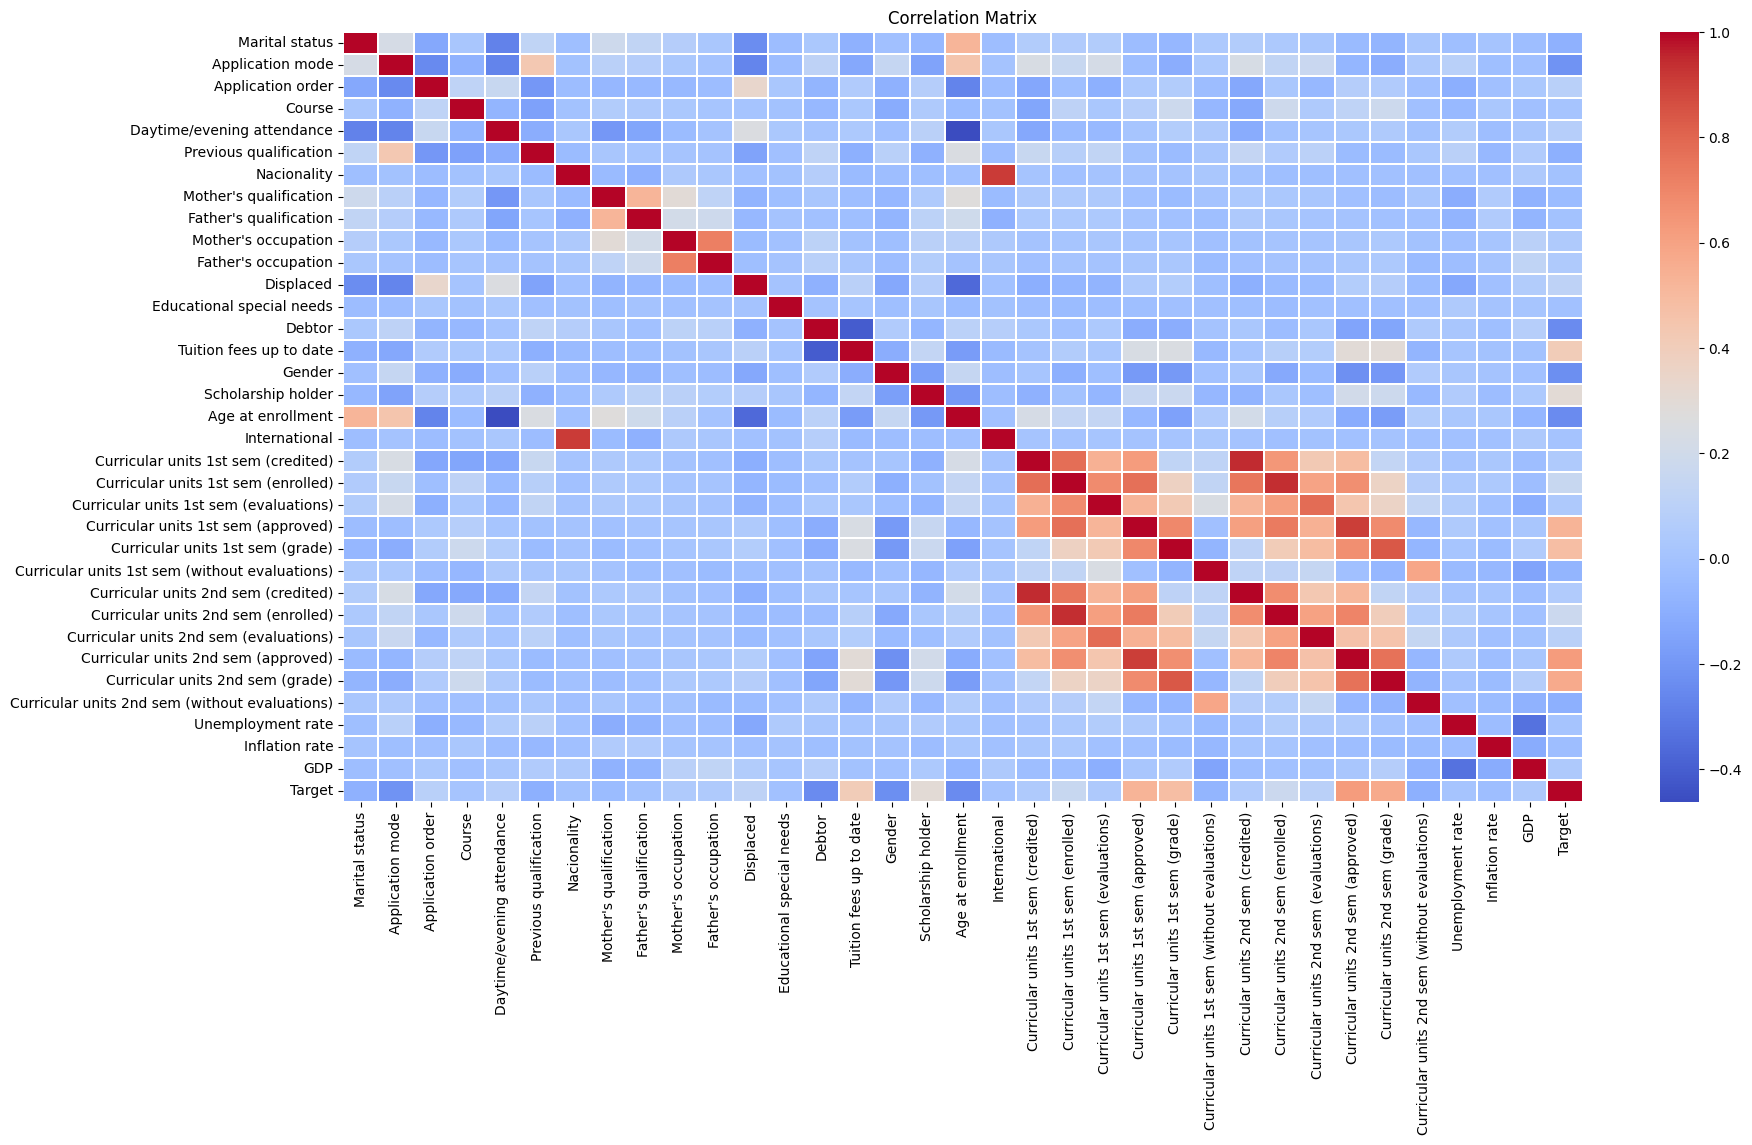

In [19]:
corr_matrix=df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".1f", linewidths=0.1)
plt.title('Correlation Matrix')
plt.show()

In [18]:
curricular=['Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)',
       'Target']
df[curricular].head()

,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Target
0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,0
1,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,2
2,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,0
3,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,2
4,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,2


In [75]:
sns.pairplot(df[curricular],hue='Target')
plt.show()

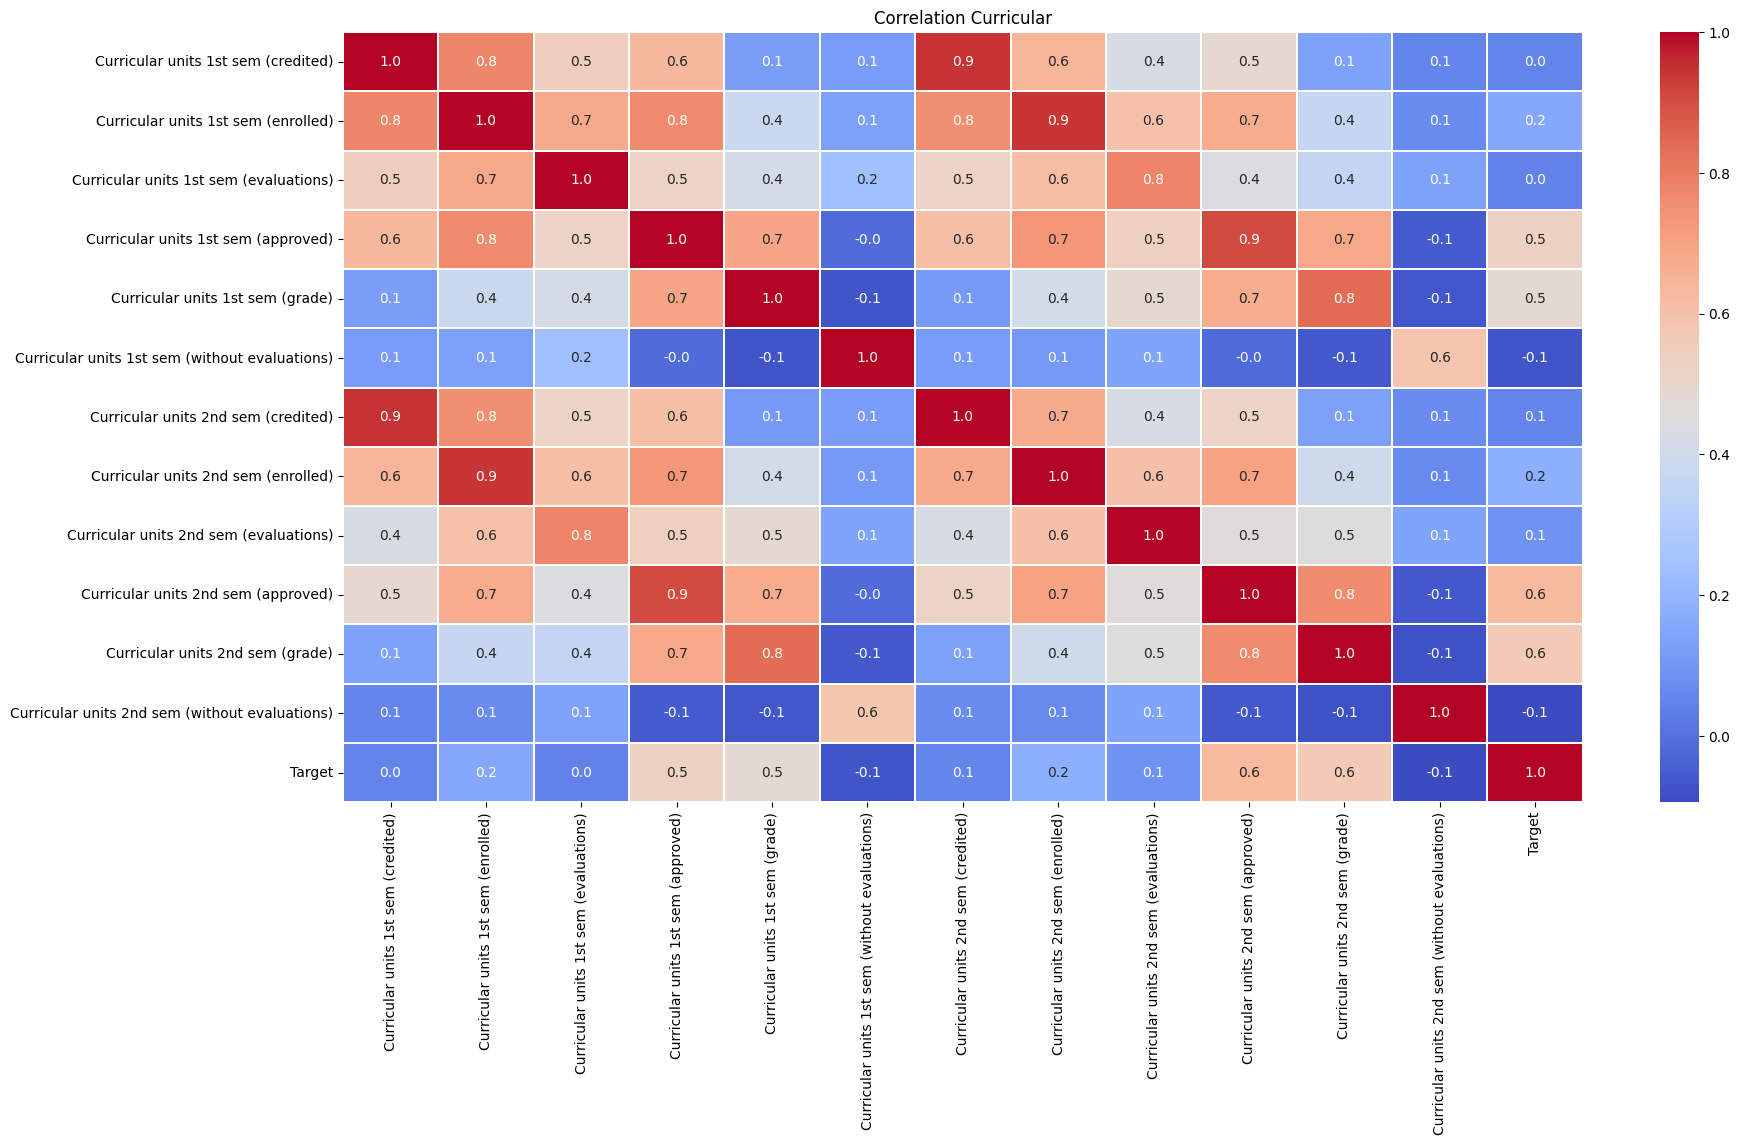

In [20]:
corr_curricular=df[curricular].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_curricular, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.1)
plt.title('Correlation Curricular')
plt.show()

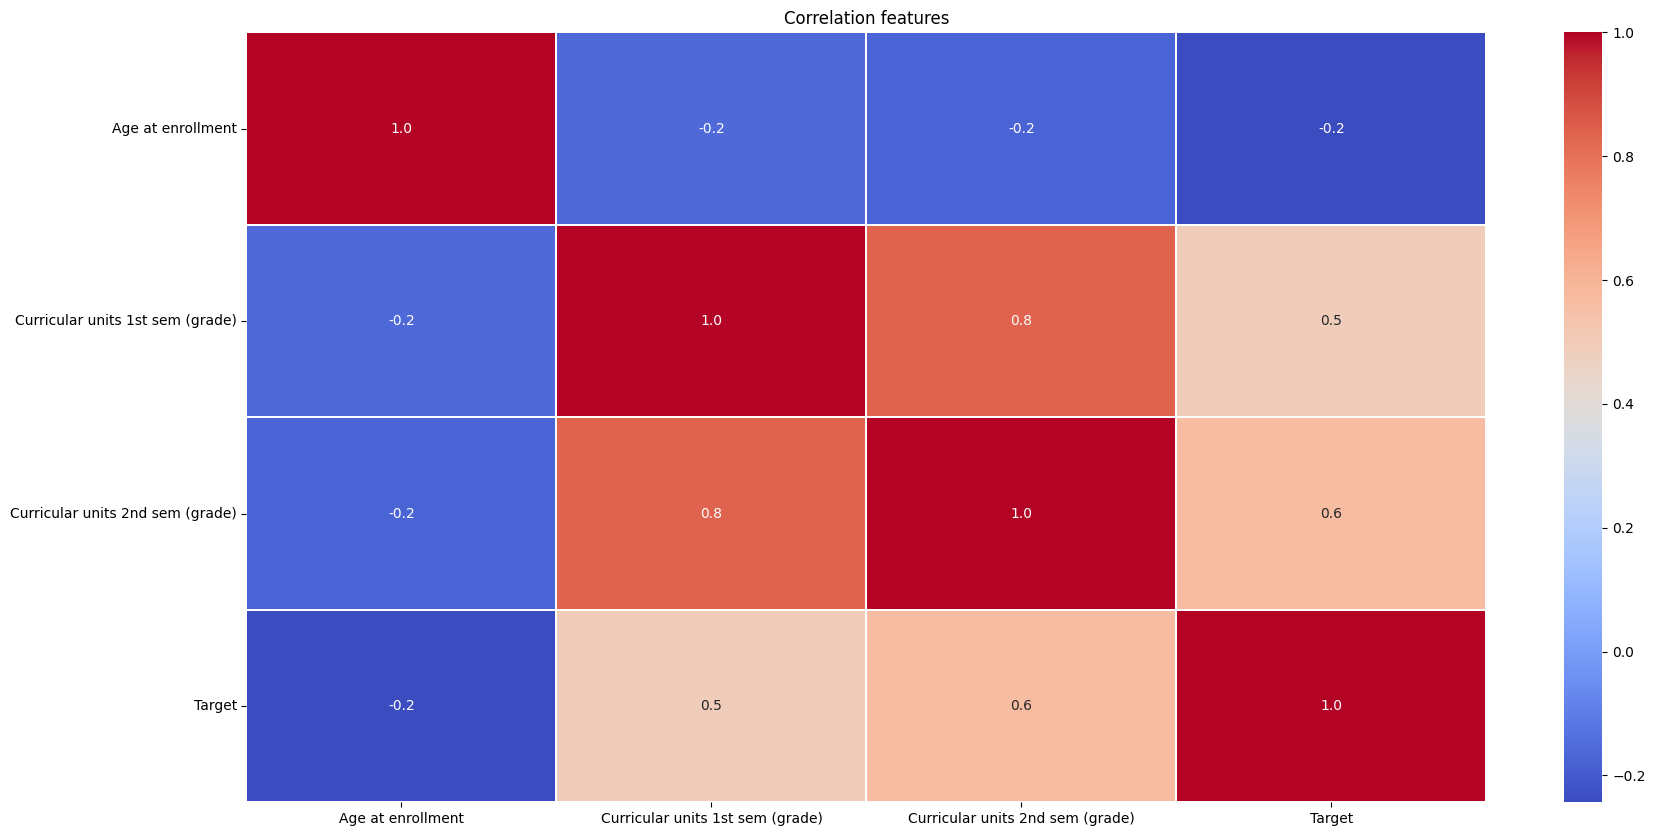

In [21]:
selected_features = ['Age at enrollment', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)', 'Target']
corr_features=df[selected_features].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_features, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.1)
plt.title('Correlation features')
plt.show()

In [22]:
correlation_with_target=df.corr()['Target'].sort_values(ascending=False)
print("Correlation with Target:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
print(correlation_with_target)

Correlation with Target:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Target                                            1.000000
Curricular units 2nd sem (approved)               0.624157
Curricular units 2nd sem (grade)                  0.566827
Curricular units 1st sem (approved)               0.529123
Curricular units 1st sem (grade)                  0.485207
Tuition fees up to date                           0.409827
Scholarship holder                                0.297595
Curricular units 2nd sem (enrolled)               0.175847
Curricular units 1st sem (enrolled)               0.155974
Displaced                                         0.113986
Curricular units 2nd sem (evaluations)            0.092721
Application order                                 0.089791
Daytime/evening attendance                        0.075107
Curricular units 2nd sem (credited)               0.054004
Father's occupation                               0.051702
Mother's occupation                               0.04

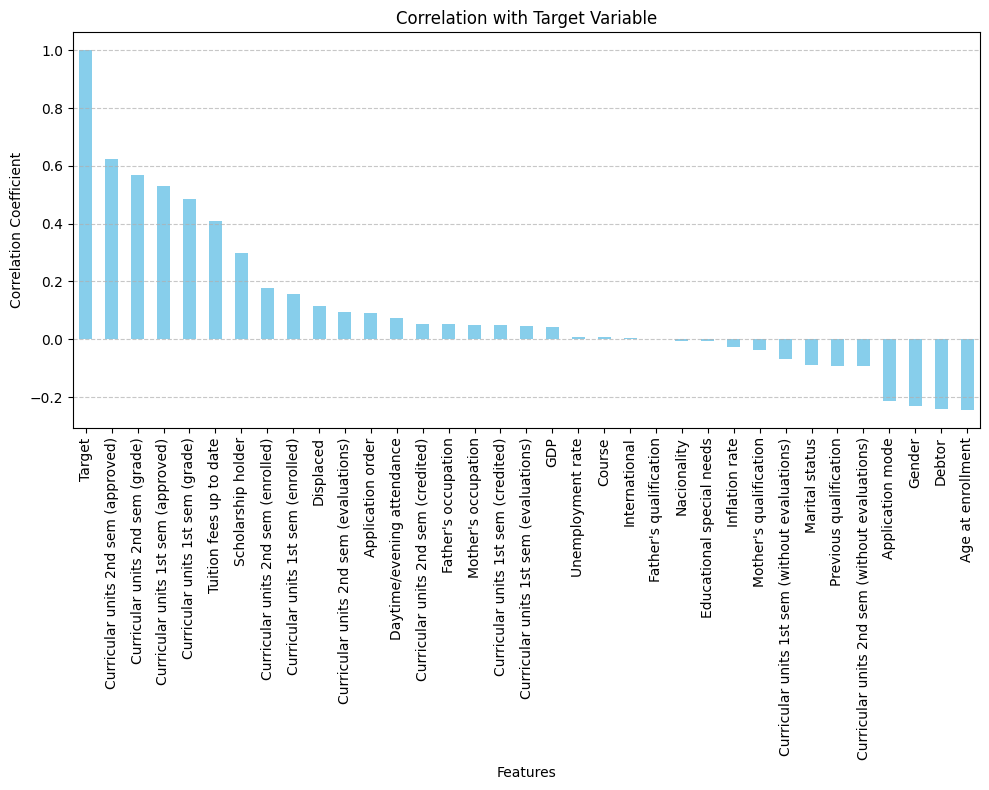

In [23]:
plt.figure(figsize=(10, 8))
correlation_with_target.plot(kind='bar', color='skyblue')
plt.title('Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
df_new=df.copy()

In [25]:
import autoviz
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
dftc=AV.AutoViz(df_new)

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)
Shape of your Data Set loaded: (4424, 35)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  5
    Number of Integer-Categorical Columns =  22
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  8
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number o

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Marital status,int64,0.000000,0,1.000000,6.000000,Column has 505 outliers greater than upper bound (1.00) or lower than lower bound(1.00). Cap them or remove them.
Application mode,int64,0.000000,0,1.000000,18.000000,No issue
Application order,int64,0.000000,0,0.000000,9.000000,Column has 541 outliers greater than upper bound (3.50) or lower than lower bound(-0.50). Cap them or remove them.
Course,int64,0.000000,0,1.000000,17.000000,No issue
Daytime/evening attendance,int64,0.000000,0,0.000000,1.000000,No issue
Previous qualification,int64,0.000000,0,1.000000,17.000000,Column has 707 outliers greater than upper bound (1.00) or lower than lower bound(1.00). Cap them or remove them.
Nacionality,int64,0.000000,0,1.000000,21.000000,Column has 110 outliers greater than upper bound (1.00) or lower than lower bound(1.00). Cap them or remove them.
Mother's qualification,int64,0.000000,0,1.000000,29.000000,No issue
Father's qualification,int64,0.000000,0,1.000000,34.000000,No issue
Mother's occupation,int64,0.000000,0,1.000000,32.000000,Column has 84 outliers greater than upper bound (17.50) or lower than lower bound(-2.50). Cap them or remove them.


Number of All Scatter Plots = 15
All Plots done
Time to run AutoViz = 41 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [27]:
df_new=df.drop_duplicates()
df_new.shape

(4424, 35)

## **Model Building Training Clasification**

In [28]:
y=df_new['Target']
X=df_new.drop(['Target'],axis=1)

# Preparar los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Crear el modelo
train_data = lgb.Dataset(X_train, label=y_train)
params = {"boosting_type": "gbdt","objective": "multiclass","metric": "multi_logloss", 'num_class':3,      
                         'n_estimators': 1024,
                         'reg_alpha': 0.1, 'reg_lambda': 10, 
                         'colsample_bytree': 0.8, 'subsample': 0.8,
                         'learning_rate': 0.05, 'num_leaves': 64, 'min_child_samples': 62,
                         'max_bin':245, "extra_trees": True,
                    }

# Entrenar el modelo
model = lgb.train(params, train_data, num_boost_round=100)

# Realizar predicciones
y_pred = model.predict(X_test)
y_pred_class = [np.argmax(pred) for pred in y_pred]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 937
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 33
[LightGBM] [Info] Start training from score -1.135451
[LightGBM] [Info] Start training from score -1.717974
[LightGBM] [Info] Start training from score -0.694561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [29]:
# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)
print("Informe de clasificación:")
print(classification_report(y_test, y_pred_class))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_class))

Accuracy: 0.7536723163841808
Informe de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       284
           1       0.49      0.42      0.45       159
           2       0.80      0.90      0.84       442

    accuracy                           0.75       885
   macro avg       0.70      0.68      0.69       885
weighted avg       0.75      0.75      0.75       885

Matriz de confusión:
[[204  39  41]
 [ 33  67  59]
 [ 14  32 396]]


In [32]:
# Obtener la importancia de las características
feature_importance = model.feature_importance()

# Crear un DataFrame con la importancia de las características
feature_importance_df = pd.DataFrame({'Característica': X.columns, 'Importancia': feature_importance})

# Ordenar el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)
feature_importance_df

,Característica,Importancia
33,GDP,3917
32,Inflation rate,3560
11,Displaced,2910
3,Course,2763
15,Gender,2454
31,Unemployment rate,2371
16,Scholarship holder,2283
8,Father's qualification,2013
23,Curricular units 1st sem (grade),1910
1,Application mode,1636


In [33]:
# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='Característica', y='Importancia', data=feature_importance_df.head(10))
plt.title('Importancia de las características')
plt.xlabel('Característica')
plt.ylabel('Importancia')
plt.xticks(rotation=90)
plt.show()